In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score)
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [395]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Dataset

In [396]:
# 1. Data Loading
# ===============
# Load all datasets

orders_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/olist_orders_dataset.csv')
reviews_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/olist_order_reviews_dataset.csv')
order_items_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/olist_order_items_dataset.csv')
payments_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/olist_order_payments_dataset.csv')
products_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/olist_products_dataset.csv')
customers_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/olist_customers_dataset.csv')
sellers_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/olist_sellers_dataset.csv')
product_translation_df = pd.read_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/product_category_name_translation.csv')

# Exploring the dataset to identify the id collumns in different datasets to create a final merged dtaframe

In [397]:
print("==================Order Data:==================\n")
print(orders_df.head(),"\n")

print("==================Review Data:==================\n")
print(reviews_df.head(),"\n")

print("==================Order items Data:==================\n")
print(order_items_df.head(),"\n")

print("==================Payments Data:==================\n")
print(payments_df.head(),"\n")

print("==================Products Data:==================\n")
print(products_df.head(),"\n")

print("==================Customer Data:==================\n")
print(customers_df.head(),"\n")

print("==================Seller Data:==================\n")
print(sellers_df.head(),"\n")

print("==================Product Translation:==================\n")
print(product_translation_df.head(),"\n")

==================Order Data:==================

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06  2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39  2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   

# Merge DF

In [398]:
#1. Merge Order - order items
print('rows before merge',orders_df.shape)
order_item_merged_df = order_items_df.merge(orders_df,on='order_id',how='inner')
print('rows after merge',order_item_merged_df.shape)

rows before merge (99441, 8)
rows after merge (112650, 14)


In [399]:
order_item_merged_df.isna().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0
customer_id,0
order_status,0
order_purchase_timestamp,0


In [400]:
#2.Merge Order - order items - reviews
print('rows before merge',order_item_merged_df.shape)
order_reviews_merged_df = order_item_merged_df.merge(reviews_df,on='order_id',how='inner')
print('rows after merge',order_reviews_merged_df.shape)

rows before merge (112650, 14)
rows after merge (112372, 20)


In [401]:
#3. Merge Order - order items - reviews - product
print('rows before merge',order_reviews_merged_df.shape)
order_reviews_product_merged_df = order_reviews_merged_df.merge(products_df,on='product_id',how='inner')
print('rows after merge',order_reviews_product_merged_df.shape)

rows before merge (112372, 20)
rows after merge (112372, 28)


In [402]:
#4. Merge Order - order items - reviews - product - payments
print('rows before merge',order_reviews_product_merged_df.shape)
order_reviews_product_payments_merged_df = order_reviews_product_merged_df.merge(payments_df,on='order_id',how='inner')
print('rows after merge',order_reviews_product_payments_merged_df.shape)

rows before merge (112372, 28)
rows after merge (117329, 32)


In [403]:
#5. Merge Order - order items - reviews - product - payments - customer
print('rows before merge',order_reviews_product_payments_merged_df.shape)
order_reviews_product_payments_customer_merged_df = order_reviews_product_payments_merged_df.merge(customers_df,on='customer_id',how='inner')
print('rows after merge',order_reviews_product_payments_customer_merged_df.shape)

rows before merge (117329, 32)
rows after merge (117329, 36)


In [404]:
#6. Merge Order - order items - reviews - product - payments - customer - seller info
print('rows before merge',order_reviews_product_payments_customer_merged_df.shape)
order_reviews_product_payments_customer_seller_merged_df = order_reviews_product_payments_customer_merged_df.merge(sellers_df,on='seller_id',how='inner')
print('rows after merge',order_reviews_product_payments_customer_seller_merged_df.shape)

rows before merge (117329, 36)
rows after merge (117329, 39)


In [405]:
#7. Merge Order - order items - reviews - product - payments - customer - product english  translation
print('rows before merge',order_reviews_product_payments_customer_seller_merged_df.shape)
orders_final_merged_df = order_reviews_product_payments_customer_seller_merged_df.merge(product_translation_df,on='product_category_name',how='inner')
print('rows after merge',orders_final_merged_df.shape)

rows before merge (117329, 39)
rows after merge (115609, 40)


# Preprocessing

## Handle Missing Value



### order delivery related nulls

In [406]:
orders_final_merged_df.isna().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0
customer_id,0
order_status,0
order_purchase_timestamp,0


In [407]:
print(f"{orders_final_merged_df['order_delivered_customer_date'].isna().sum().sum()/len(orders_final_merged_df)*100:.3f}%")

2.076%


Since order_delivered_customer_date null values are only 2% and also it is important feature to identify delivery date and order fulfillment. We can drop null values from this column

In [408]:
orders_final_merged_df.dropna(subset=['order_delivered_customer_date'],inplace=True)
orders_final_merged_df.isna().sum()

,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0
customer_id,0
order_status,0
order_purchase_timestamp,0


In [409]:
print(f"{orders_final_merged_df['order_delivered_carrier_date'].isna().sum().sum()/len(orders_final_merged_df)*100:.3f}%")
print(f"{orders_final_merged_df['order_approved_at'].isna().sum().sum()/len(orders_final_merged_df)*100:.3f}%")

0.001%
0.012%


In [410]:
orders_final_merged_df.dropna(subset=['order_approved_at'],inplace=True)
print(f"{orders_final_merged_df['order_delivered_carrier_date'].isna().sum().sum()/len(orders_final_merged_df)*100:.3f}%")
print(f"{orders_final_merged_df['order_approved_at'].isna().sum().sum()/len(orders_final_merged_df)*100:.3f}%")

0.001%
0.000%


In [411]:
orders_final_merged_df.dropna(subset=['order_delivered_carrier_date'],inplace=True)
print(f"{orders_final_merged_df['order_delivered_carrier_date'].isna().sum().sum()/len(orders_final_merged_df)*100:.3f}%")
orders_final_merged_df.isna().sum()

0.000%


,0
order_id,0
order_item_id,0
product_id,0
seller_id,0
shipping_limit_date,0
price,0
freight_value,0
customer_id,0
order_status,0
order_purchase_timestamp,0


### Product related missing value

In [412]:
orders_final_merged_df[orders_final_merged_df['product_height_cm'].isna()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
60507,85f8ad45e067abd694b627859fa57453,1,09ff539a621711667c43eba6a3bd8466,8b8cfc8305aa441e4239358c9f6f2485,2017-02-03 21:40:02,1934.0,27.0,1d088dea8732788ec35dd4ee6dd76112,delivered,2017-01-29 21:40:02,2017-01-30 22:32:20,2017-02-02 05:04:58,2017-02-07 10:46:00,2017-03-08 00:00:00,125af5098b160c059cd60bafcc1f6ad1,5,NaN,NaN,2017-02-08 00:00:00,2017-02-09 10:09:24,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN,1,credit_card,10,1961.0,69b2b29382af03e03e486ad307a76000,90160,porto alegre,RS,86020,londrina,PR,baby


Checking the dimension values in other rows if the product appeared at any other date or order which can be used to impute the missing field

In [413]:
orders_final_merged_df[orders_final_merged_df['product_id']=='09ff539a621711667c43eba6a3bd8466']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
60507,85f8ad45e067abd694b627859fa57453,1,09ff539a621711667c43eba6a3bd8466,8b8cfc8305aa441e4239358c9f6f2485,2017-02-03 21:40:02,1934.0,27.0,1d088dea8732788ec35dd4ee6dd76112,delivered,2017-01-29 21:40:02,2017-01-30 22:32:20,2017-02-02 05:04:58,2017-02-07 10:46:00,2017-03-08 00:00:00,125af5098b160c059cd60bafcc1f6ad1,5,NaN,NaN,2017-02-08 00:00:00,2017-02-09 10:09:24,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN,1,credit_card,10,1961.0,69b2b29382af03e03e486ad307a76000,90160,porto alegre,RS,86020,londrina,PR,baby


Since we have only 1 row related to that product we will check at category level

In [414]:
orders_final_merged_df[(orders_final_merged_df['product_category_name_english']=='baby') &
                       (orders_final_merged_df['seller_state']=='PR') ]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
157,0066a1fdaee16ad5022c5ef979d0b661,1,2fb0efd1f61f186ffdda9e8ec70f27f2,1d8dbc4f32378d715c717c1c1fc57bae,2018-06-14 20:17:26,139.0,87.28,f19b59fc51f101023eb15bfbcca65f31,delivered,2018-06-10 19:52:27,2018-06-10 20:17:26,2018-06-11 14:44:00,2018-06-16 15:38:48,2018-07-16 00:00:00,72bd80534b0e73c14829319464e72cdc,5,NaN,NaN,2018-06-17 00:00:00,2018-06-19 23:25:15,bebes,37.0,224.0,2.0,4075.0,73.0,14.0,48.0,1,credit_card,9,226.28,08b76bd6862f5b38fafcb80a4eac3bee,26525,nilopolis,RJ,86706,arapongas,PR,baby
727,01aa38b66d95377a4f276f78742aca15,1,e7db7c40ea6647c808d48581f1308d88,1d8dbc4f32378d715c717c1c1fc57bae,2018-03-07 13:30:37,109.9,12.72,3e92daf13094e2b667e2f2c38a4ce969,delivered,2018-03-01 13:16:25,2018-03-01 13:30:37,2018-03-02 16:57:14,2018-03-03 15:48:44,2018-03-13 00:00:00,61c830647c9e5a0412daacf2dd41762d,5,NaN,NaN,2018-03-04 00:00:00,2018-03-06 19:25:46,bebes,59.0,235.0,2.0,9400.0,75.0,15.0,50.0,1,credit_card,2,122.62,fd07960753dd725c1fd626b155846b1d,86081,londrina,PR,86706,arapongas,PR,baby
774,01c18108db50c163daf7dfe461093fb7,1,b042c934bd8f4316e7b38633aa14266b,1d8dbc4f32378d715c717c1c1fc57bae,2017-06-30 18:05:15,109.9,18.02,cee3e95e0b9944bf7c7c6881c286564b,delivered,2017-06-22 17:53:59,2017-06-22 18:05:15,2017-07-03 14:36:50,2017-07-06 17:12:55,2017-07-18 00:00:00,a4fd3d012f05ba18e3abf2e1be71573c,5,NaN,NaN,2017-07-07 00:00:00,2017-07-08 03:15:42,bebes,47.0,235.0,2.0,9400.0,75.0,15.0,50.0,1,credit_card,1,127.92,0357aaa4d93f1704a3970255a474eeee,12513,guaratingueta,SP,86706,arapongas,PR,baby
1372,032de54ca8e40cca1098da6c68ba92b3,1,43cb1d661a38ba864fc53fe1b6edb0ed,e48b04bf1aa1ef711caebeb7aede6180,2017-10-03 08:04:18,39.9,13.37,ae98e7ef8bbb639184da4566b1e7f19e,delivered,2017-09-26 07:58:27,2017-09-27 08:04:18,2017-09-27 19:18:46,2017-09-30 14:07:29,2017-10-18 00:00:00,18b94de202d11bb20603ccb68b760f99,5,NaN,NaN,2017-10-01 00:00:00,2017-10-01 17:39:57,bebes,21.0,414.0,1.0,625.0,26.0,14.0,12.0,1,credit_card,3,53.27,8886966f79ad4b54b06c2fbbd66b6b5e,84400,prudentopolis,PR,80240,curitiba,PR,baby
1962,0466015790ddd0ed7a2e65a6ca039c73,1,955d159d5f3a5d16c3808fcb7705224f,066a6914e1ebf3ea95a216c73a986b91,2018-04-19 13:30:29,14.0,18.23,bec34e289955dde2437d70e6d8be480d,delivered,2018-04-13 12:40:08,2018-04-13 13:30:29,2018-04-17 13:32:30,2018-04-24 21:44:44,2018-05-10 00:00:00,4994d97624335dd1843253bd47f494e1,4,boa,entregue antesdo previsto,2018-04-25 00:00:00,2018-04-27 21:00:14,bebes,25.0,148.0,1.0,50.0,16.0,14.0,14.0,1,credit_card,1,64.46,4329781165a441a91f38a4c583cf5131,11673,caraguatatuba,SP,85863,foz do iguacu,PR,baby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113493,fb60f4b1a57af4307122b7997fc52243,1,93ca601fb17b9bc29a7fcaa4e40f015b,1d8dbc4f32378d715c717c1c1fc57bae,2017-05-14 23:05:19,110.0,19.36,8e70736440f6e4fd50223adf95ead0cc,delivered,2017-05-04 22:57:10,2017-05-04 23:05:19,2017-05-09 11:28:21,2017-05-16 15:23:01,2017-06-02 00:00:00,32664635439c3930cc10b6ca3a079121,3,NaN,NaN,2017-05-17 00:00:00,2017-05-18 20:53:55,bebes,47.0,224.0,2.0,9400.0,75.0,15.0,50.0,1,credit_card,10,129.36,3299a547368c58a4d2241b2a5189d7d7,30840,belo horizonte,MG,86706,arapongas,PR,baby
113502,fb66173878dcc988e4e3e1151901b

There are large as well as small values which can lead to incorrect average calculation

We can use KNN Imputer or regression based method to impute the value

In [415]:
print('Before dropping missing',orders_final_merged_df.shape)
orders_final_merged_df.dropna(subset=['product_length_cm','product_weight_g','product_length_cm','product_height_cm','product_width_cm'],inplace=True)
print('After dropping missing',orders_final_merged_df.shape)

Before dropping missing (113194, 40)
After dropping missing (113193, 40)


## Check Duplicates

In [416]:
orders_final_merged_df.duplicated().sum()

np.int64(0)

# Save Merged and Preprocessed dataset

In [417]:
orders_final_merged_df.shape

(113193, 40)

# Feature Engineering

In [418]:
df = orders_final_merged_df.copy()

In [419]:
# Convert column datatypes for consistency
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

df['price'] = df['price'].astype(float)
df['freight_value'] = df['freight_value'].astype(float)
df['payment_value'] = df['payment_value'].astype(float)
df['product_photos_qty'] = df['product_photos_qty'].astype(float)
df['product_weight_g'] = df['product_weight_g'].astype(float)
df['product_length_cm'] = df['product_length_cm'].astype(float)
df['product_height_cm'] = df['product_height_cm'].astype(float)
df['product_width_cm'] = df['product_width_cm'].astype(float)

df['payment_installments'] = df['payment_installments'].astype(int)


df['order_status'] = df['order_status'].astype('category')
df['payment_type'] = df['payment_type'].astype('category')
df['customer_state'] = df['customer_state'].astype('category')
df['customer_city'] = df['customer_city'].astype('category')
df.drop(columns='product_category_name',inplace=True)
df.rename(columns={'product_category_name_english':'product_category'},inplace=True)
df['product_category'] = df['product_category'].astype('category')


df['review_score'] = df['review_score'].astype('int')


In [420]:
# Calculate delivery days
df['delivery_days'] = (df['order_delivered_customer_date'] -
                             df['order_purchase_timestamp']).dt.days

# Calculate if there was a delay in delivery , 1: late, 0: not late
df['is_late'] = (df['order_delivered_customer_date'] >
                          df['order_estimated_delivery_date']).astype(int)


# Calculate the order freight ratio.
df['order_freight_ratio'] = df['freight_value'] / df['price']

df['cust_satisfaction'] = df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

## Define feature and target columns

In [421]:
id_columns = ['order_id','product_id','customer_id']
numerical_fetaures = ['price', 'freight_value', 'payment_value', 'product_photos_qty', 'product_weight_g', 'product_length_cm',
                   'product_height_cm','product_width_cm','delivery_days','order_freight_ratio','payment_installments']

binary_features = ['is_late']

categorical_features = ['order_status','payment_type','customer_state','product_category']

target_variable = ['cust_satisfaction']

In [422]:
orders_cleaned_df = df[id_columns+numerical_fetaures+categorical_features+binary_features+target_variable]

In [423]:
orders_cleaned_df.isna().sum().sum()

np.int64(0)

In [424]:
orders_cleaned_df.duplicated().sum()

np.int64(11219)

In [425]:
orders_cleaned_df[orders_cleaned_df.duplicated()]

,order_id,product_id,customer_id,price,freight_value,payment_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_days,order_freight_ratio,payment_installments,order_status,payment_type,customer_state,product_category,is_late,cust_satisfaction
14,0008288aa423d2a3f00fcb17cd7d8719,368c6c730842d78016ad823897a372db,2355af7c75e7c98b43a87b2a7f210dc5,49.90,13.37,126.54,2.0,1650.0,30.0,22.0,30.0,12,0.267936,1,delivered,boleto,SP,garden_tools,0,1
41,001ab0a7578dd66cd4b0a71f5b6e1e41,0b0172eb0fd18479d29c3bc122c058c2,8bb3bef4e75a95524235cdc11a7331af,24.89,17.63,127.56,2.0,150.0,22.0,13.0,15.0,21,0.708317,1,delivered,boleto,BA,electronics,0,1
42,001ab0a7578dd66cd4b0a71f5b6e1e41,0b0172eb0fd18479d29c3bc122c058c2,8bb3bef4e75a95524235cdc11a7331af,24.89,17.63,127.56,2.0,150.0,22.0,13.0,15.0,21,0.708317,1,delivered,boleto,BA,electronics,0,1
47,001d8f0e34a38c37f7dba2a37d4eba8b,e67307ff0f15ade43fcb6e670be7a74c,d987da9fb4086ab7c2c0f83963cd6722,18.99,7.78,53.54,3.0,150.0,43.0,13.0,14.0,11,0.409689,2,delivered,credit_card,SP,health_beauty,1,0
74,002c9def9c9b951b1bec6d50753c9891,2d9ff06c8870a518f5f6909774e140fb,06cf02bf583b05fd91bc8eec0f1b4c3f,78.00,8.90,173.80,3.0,950.0,25.0,10.0,36.0,3,0.114103,1,delivered,credit_card,SP,housewares,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115576,ffecd5a79a0084f6a592288c67e3c298,50fd2b788dc166edd20512370dac54df,8afa5a415d65a08e3a68b1d7f9ddd8a5,21.90,15.79,113.07,1.0,150.0,30.0,10.0,20.0,29,0.721005,1,delivered,credit_card,BA,electronics,1,0
115594,fff8287bbae429a99bb7e8c21d151c41,bee2e070c39f3dd2f6883a17a5f0da45,6c1e92a209dbf868706caa831090941e,180.00,48.14,456.28,4.0,175.0,20.0,20.0,20.0,20,0.267444,4,delivered,credit_card,PB,computers_accessories,0,1
115600,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,4d3abb73ceb86353aeadbe698aa9d5cb,55.00,34.19,356.76,4.0,350.0,16.0,14.0,11.0,21,0.621636,1,delivered,boleto,PE,watches_gifts,0,1
115601,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,4d3abb73ceb86353aeadbe698aa9d5cb,55.00,34.19,356.76,4.0,350.0,16.0,14.0,11.0,21,0.621636,1,delivered,boleto,PE,watches_gifts,0,1


In [426]:
orders_cleaned_df[(orders_cleaned_df['order_id']=='fffb9224b6fc7c43ebb0904318b10b5f') &
         (orders_cleaned_df['product_id']=='43423cdffde7fda63d0414ed38c11a73')
         ]

,order_id,product_id,customer_id,price,freight_value,payment_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_days,order_freight_ratio,payment_installments,order_status,payment_type,customer_state,product_category,is_late,cust_satisfaction
115599,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,4d3abb73ceb86353aeadbe698aa9d5cb,55.0,34.19,356.76,4.0,350.0,16.0,14.0,11.0,21,0.621636,1,delivered,boleto,PE,watches_gifts,0,1
115600,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,4d3abb73ceb86353aeadbe698aa9d5cb,55.0,34.19,356.76,4.0,350.0,16.0,14.0,11.0,21,0.621636,1,delivered,boleto,PE,watches_gifts,0,1
115601,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,4d3abb73ceb86353aeadbe698aa9d5cb,55.0,34.19,356.76,4.0,350.0,16.0,14.0,11.0,21,0.621636,1,delivered,boleto,PE,watches_gifts,0,1
115602,fffb9224b6fc7c43ebb0904318b10b5f,43423cdffde7fda63d0414ed38c11a73,4d3abb73ceb86353aeadbe698aa9d5cb,55.0,34.19,356.76,4.0,350.0,16.0,14.0,11.0,21,0.621636,1,delivered,boleto,PE,watches_gifts,0,1


In [427]:
print('Before dropping duplicates',orders_cleaned_df.shape)
orders_cleaned_df.drop_duplicates(inplace=True)
print('After dropping duplicates',orders_cleaned_df.shape)


Before dropping duplicates (113193, 20)
After dropping duplicates (101974, 20)


In [428]:
# orders_cleaned_df.to_csv('/content/drive/MyDrive/Data Analytics Sem2 (Spring)/Main Assignment/data/olist/Preprocessed_data/orders_final_merged_preprocessed.csv',index=False)

# EDA - Exploratory data analysis

In [429]:
df1 = orders_cleaned_df.copy()

In [430]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101974 entries, 0 to 115608
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   order_id              101974 non-null  object  
 1   product_id            101974 non-null  object  
 2   customer_id           101974 non-null  object  
 3   price                 101974 non-null  float64 
 4   freight_value         101974 non-null  float64 
 5   payment_value         101974 non-null  float64 
 6   product_photos_qty    101974 non-null  float64 
 7   product_weight_g      101974 non-null  float64 
 8   product_length_cm     101974 non-null  float64 
 9   product_height_cm     101974 non-null  float64 
 10  product_width_cm      101974 non-null  float64 
 11  delivery_days         101974 non-null  int64   
 12  order_freight_ratio   101974 non-null  float64 
 13  payment_installments  101974 non-null  int64   
 14  order_status          101974 non-null  ca

In [431]:
for col in categorical_features:
  print(orders_cleaned_df[col].value_counts())


order_status
delivered    101967
canceled          7
Name: count, dtype: int64
payment_type
credit_card    75998
boleto         19449
voucher         5015
debit_card      1512
Name: count, dtype: int64
customer_state
SP    42951
RJ    13099
MG    11973
RS     5641
PR     5171
SC     3690
BA     3486
DF     2184
ES     2099
GO     2061
PE     1658
CE     1355
PA      977
MT      938
MA      747
MS      732
PB      545
RN      510
PI      501
AL      414
SE      347
TO      294
RO      256
AM      153
AC       82
AP       71
RR       39
Name: count, dtype: int64
product_category
bed_bath_table               10488
health_beauty                 9012
sports_leisure                7858
computers_accessories         6922
furniture_decor               6896
                             ...  
home_comfort_2                  24
la_cuisine                      14
cds_dvds_musicals               12
fashion_childrens_clothes        7
security_and_services            2
Name: count, Length: 71, dtype:

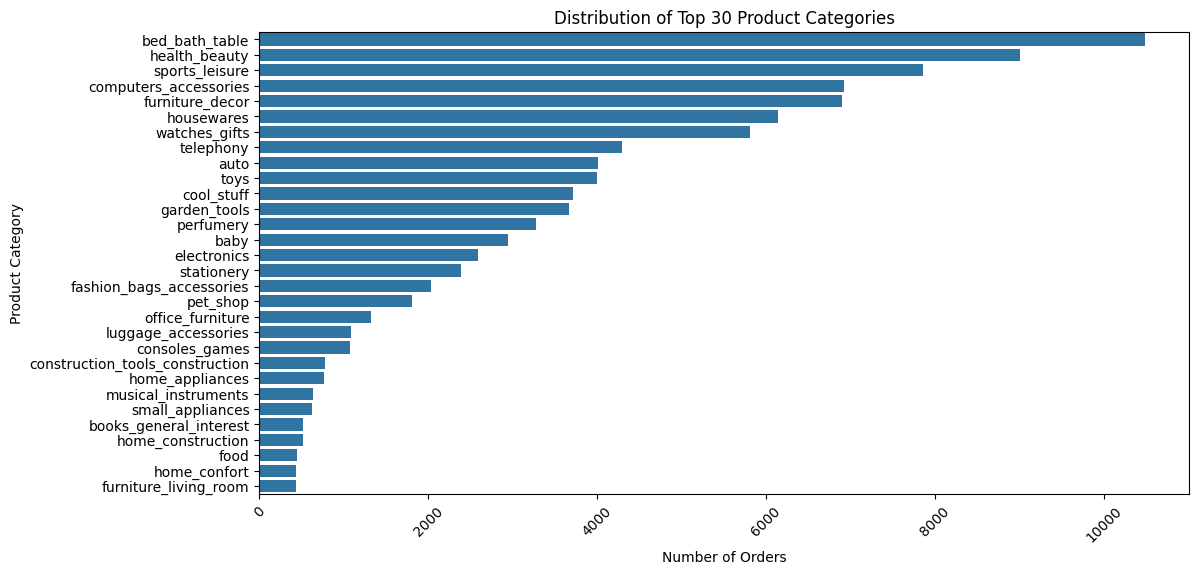

In [432]:
import matplotlib.pyplot as plt
# Plot the distribution of product categories
plt.figure(figsize=(12, 6))
sns.countplot(y='product_category', data=df1, order=df1['product_category'].value_counts().head(30).index)
plt.title('Distribution of Top 30 Product Categories')
plt.xlabel('Number of Orders')
plt.ylabel('Product Category')
plt.xticks(rotation=45)
plt.show()


The most frequenty bought product category is Bed Bath Table followed by health Beauty products and sports leisure

(0.0, 600.0)

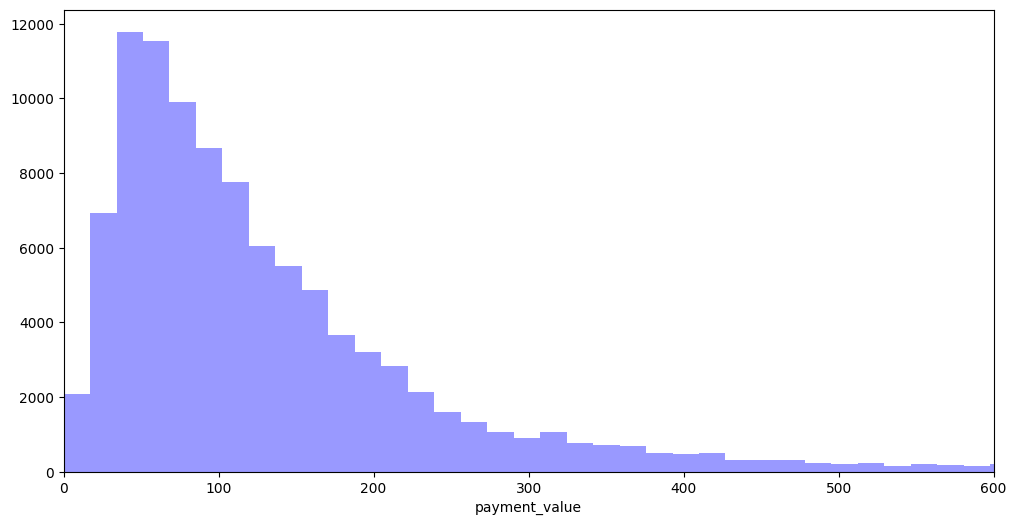

In [433]:
plt.figure(figsize=(12,6))
sns.distplot(df1['payment_value'], bins=800 ,kde=False, color='b')
plt.xlim([0, 600])

As Expected most of the times, people buy cheaply priced goods on the platform

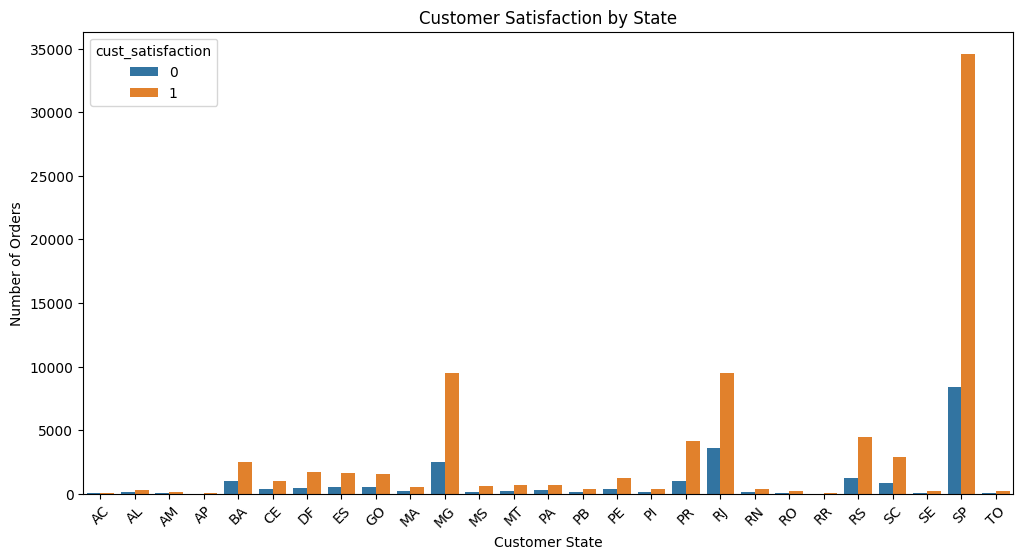

In [434]:
plt.figure(figsize=(12, 6))
sns.countplot(x='customer_state', hue='cust_satisfaction', data=df1)
plt.title('Customer Satisfaction by State')
plt.xlabel('Customer State')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.show()


The plot of customer satisfaction by state shows variation in satisfaction levels across different states. Some states exhibit higher proportions of satisfied customers compared to others.  .  Further breakdown within states by other variables, like specific product categories, could yield more granular insights.


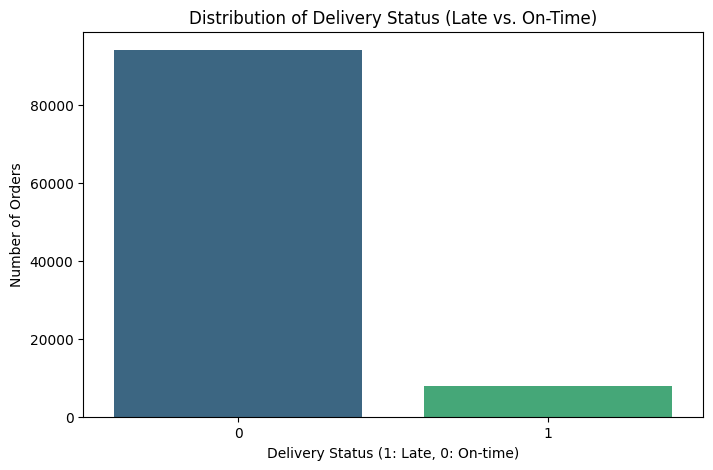

In [435]:
plt.figure(figsize=(8, 5))
sns.countplot(x='is_late', data=df1, palette='viridis')
plt.title('Distribution of Delivery Status (Late vs. On-Time)')
plt.xlabel('Delivery Status (1: Late, 0: On-time)')
plt.ylabel('Number of Orders')
plt.show()


The countplot for delivery status (late vs. on-time) shows a predominantly on-time delivery rate. A deeper analysis would involve examining the factors (e.g., product category, customer location) contributing to delivery delays. It could also be useful to analyze the impact of late deliveries on customer reviews.


In [436]:
df1['cust_satisfaction'].value_counts()/len(df1)*100

,count
cust_satisfaction,
1,77.985565
0,22.014435


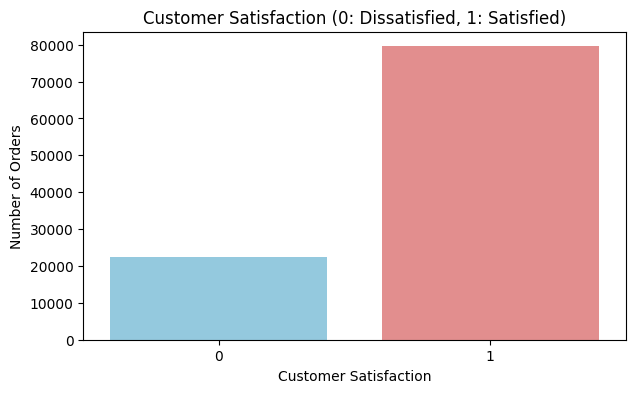

In [437]:

plt.figure(figsize=(7, 4))
sns.countplot(x='cust_satisfaction', data=df1, palette=['skyblue', 'lightcoral'])
plt.title('Customer Satisfaction (0: Dissatisfied, 1: Satisfied)')
plt.xlabel('Customer Satisfaction')
plt.ylabel('Number of Orders')
plt.show()


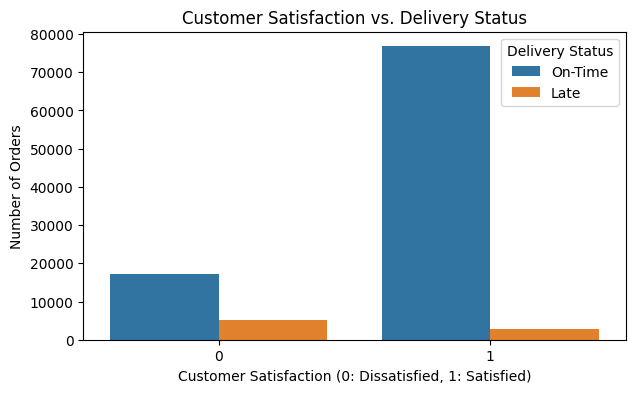

In [438]:
plt.figure(figsize=(7, 4))
sns.countplot(x='cust_satisfaction', hue='is_late', data=df1)
plt.title('Customer Satisfaction vs. Delivery Status')
plt.xlabel('Customer Satisfaction (0: Dissatisfied, 1: Satisfied)')
plt.ylabel('Number of Orders')
plt.legend(title='Delivery Status', labels=['On-Time', 'Late'])
plt.show()


Even though the delivery are on time customers remain still dissatisfied


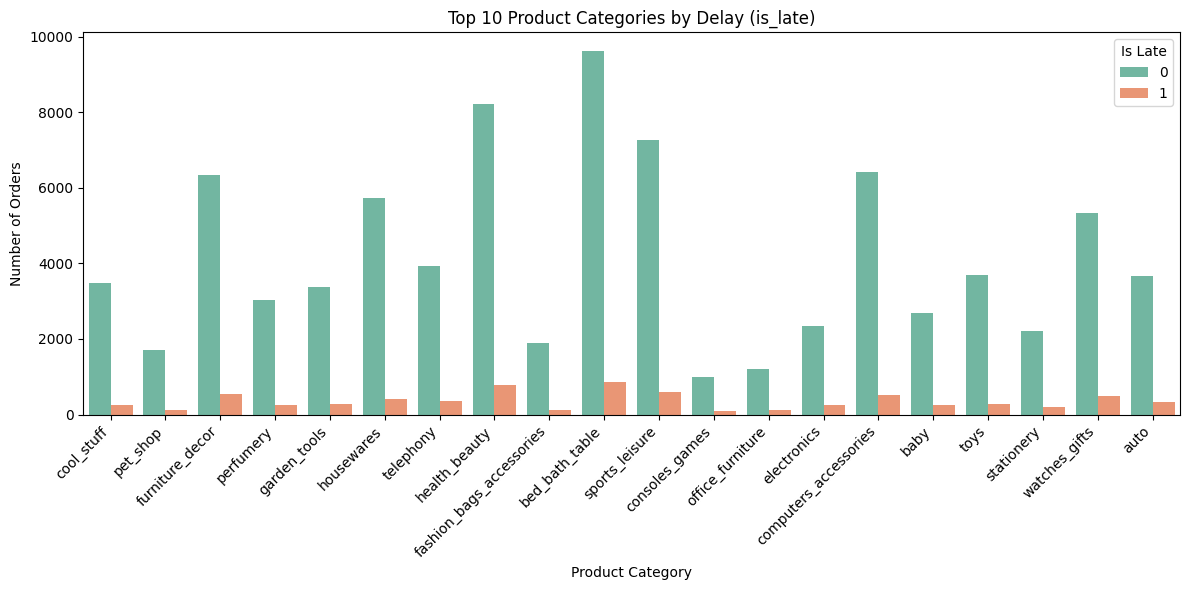

In [440]:
df1['product_category'] = df1['product_category'].astype(str).str.strip()
df1 = df1.dropna(subset=['product_category'])

top_delay_cats = (
    df1[df1['is_late'] == 1]
    .groupby('product_category')
    .size()
    .sort_values(ascending=False)
    .head(20)
    .index
)

# Step 2: Filter the data for those categories
filtered_df = df1[df1['product_category'].isin(top_delay_cats)]

# Step 3: Plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_df, x='product_category', hue='is_late', palette='Set2')

plt.title('Top 10 Product Categories by Delay (is_late)')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Is Late')
plt.tight_layout()
plt.show()

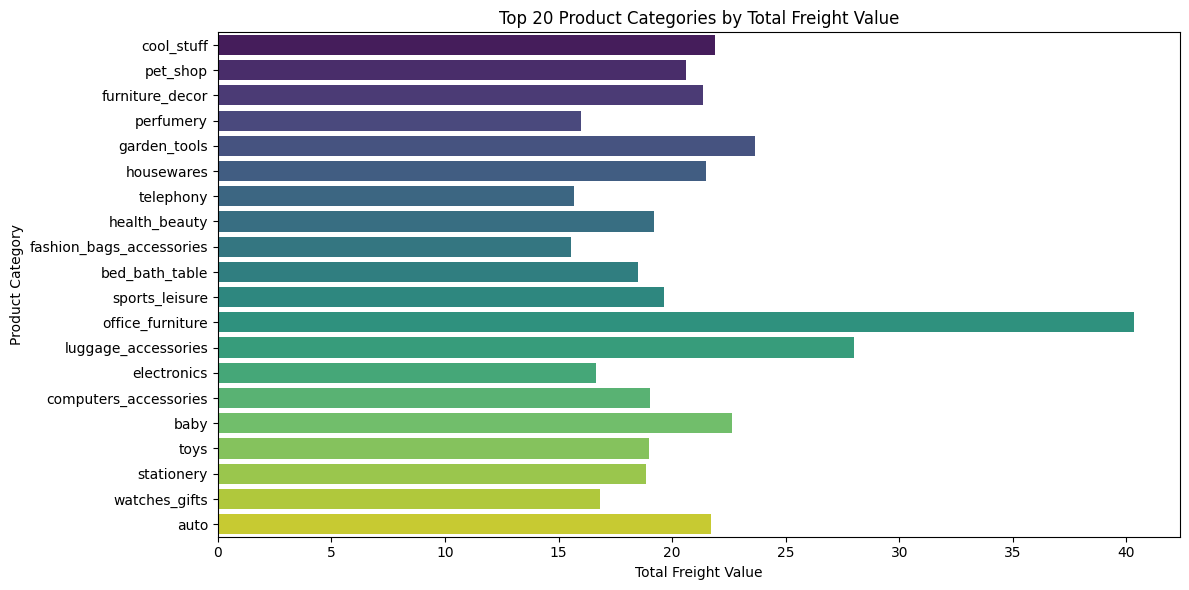

In [441]:
plt.figure(figsize=(12, 6))
top_20_categories = df1.groupby('product_category')['freight_value'].sum().nlargest(20).index
sns.barplot(x='freight_value', y='product_category', data=df1[df1['product_category'].isin(top_20_categories)], ci=None, palette='viridis')
plt.title('Top 20 Product Categories by Total Freight Value')
plt.xlabel('Total Freight Value')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


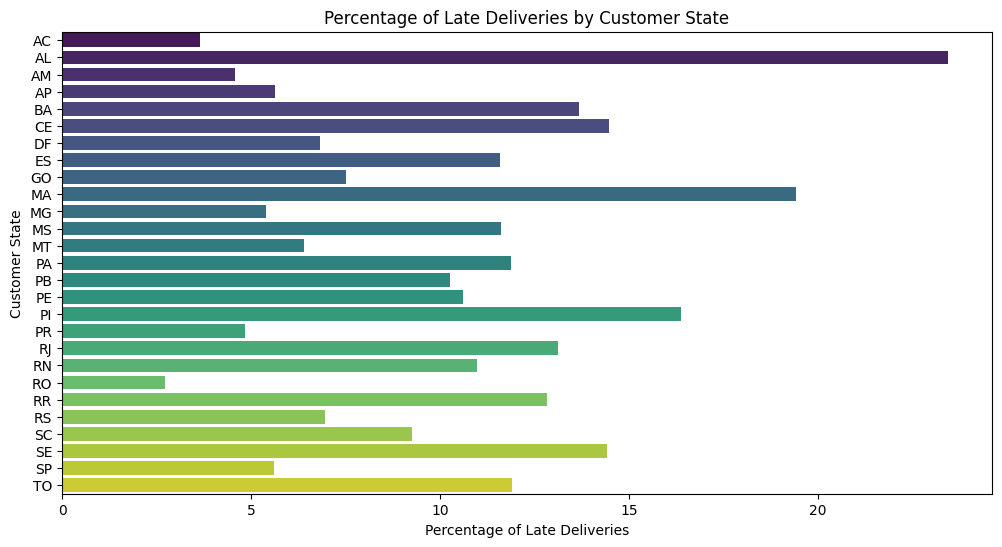

In [442]:
# Group data by customer state and calculate the percentage of late deliveries
late_deliveries_by_state = df1.groupby('customer_state')['is_late'].mean() * 100

# Sort states by percentage of late deliveries in descending order
late_deliveries_by_state = late_deliveries_by_state.sort_values(ascending=False)

# Create a bar plot to visualize the results
plt.figure(figsize=(12, 6))
sns.barplot(x=late_deliveries_by_state.values, y=late_deliveries_by_state.index,palette='viridis')
plt.title('Percentage of Late Deliveries by Customer State')
plt.xlabel('Percentage of Late Deliveries')
plt.ylabel('Customer State')
plt.show()


In [369]:
df1.head()

,order_id,product_id,customer_id,price,freight_value,payment_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_days,order_freight_ratio,payment_installments,order_status,payment_type,customer_state,product_category,is_late,cust_satisfaction
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,58.90,13.29,72.19,4.0,650.0,28.0,9.0,14.0,7,0.225637,2,delivered,credit_card,RJ,cool_stuff,0,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,239.90,19.93,259.83,2.0,30000.0,50.0,30.0,40.0,16,0.083076,3,delivered,credit_card,SP,pet_shop,0,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,199.00,17.87,216.87,2.0,3050.0,33.0,13.0,33.0,7,0.089799,5,delivered,credit_card,MG,furniture_decor,0,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,12.99,12.79,25.78,1.0,200.0,16.0,10.0,15.0,6,0.984604,2,delivered,credit_card,SP,perfumery,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,199.90,18.14,218.04,1.0,3750.0,35.0,40.0,30.0,25,0.090745,3,delivered,credit_card,SP,garden_tools,0,1


# Statistical Analysis

In [443]:
df = orders_cleaned_df.copy()

## Correlation Analysis

In [444]:
corr_matrix = orders_cleaned_df[numerical_fetaures+binary_features+target_variable].corr()

In [445]:
corr_matrix

,price,freight_value,payment_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_days,order_freight_ratio,payment_installments,is_late,cust_satisfaction
price,1.000000,0.418274,0.875618,0.050255,0.344579,0.144796,0.233118,0.172979,0.059140,-0.301488,0.300585,0.020953,0.004463
freight_value,0.418274,1.000000,0.436283,0.023698,0.612507,0.307882,0.391714,0.325203,0.210782,0.096158,0.196533,0.040553,-0.027970
payment_value,0.875618,0.436283,1.000000,0.025434,0.352496,0.156295,0.238256,0.179041,0.061709,-0.253743,0.329359,0.012576,-0.042729
product_photos_qty,0.050255,0.023698,0.025434,1.000000,0.027685,0.044505,-0.026715,0.006411,-0.026989,-0.053904,0.000187,-0.004784,0.015416
product_weight_g,0.344579,0.612507,0.352496,0.027685,1.000000,0.463383,0.580201,0.510979,0.079349,-0.106609,0.184980,0.022831,-0.022414
product_length_cm,0.144796,0.307882,0.156295,0.044505,0.463383,1.000000,0.190406,0.552631,0.063329,-0.097299,0.114428,0.014880,-0.017258
product_height_cm,0.233118,0.391714,0.238256,-0.026715,0.580201,0.190406,1.000000,0.282130,0.062264,-0.116490,0.124804,0.013764,-0.012770
product_width_cm,0.172979,0.325203,0.179041,0.006411,0.510979,0.552631,0.282130,1.000000,0.039589,-0.118991,0.139977,0.005022,-0.015087
delivery_days,0.059140,0.210782,0.061709,-0.026989,0.079349,0.063329,0.062264,0.039589,1.000000,0.075475,0.044669,0.584447,-0.276286
order_freight_ratio,-0.301488,0.096158,-0.253743,-0.053904,-0.106609,-0.097299,-0.116490,-0.118991,0.075475,1.000000,-0.173257,0.007523,-0.026735


In [446]:
corr_matrix[target_variable[0]].sort_values(ascending=False)
# corr_matrix

,cust_satisfaction
cust_satisfaction,1.000000
product_photos_qty,0.015416
price,0.004463
product_height_cm,-0.012770
product_width_cm,-0.015087
product_length_cm,-0.017258
product_weight_g,-0.022414
order_freight_ratio,-0.026735
freight_value,-0.027970
payment_installments,-0.040156


## Perform VIF analysis for numerical features

In [447]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Assuming 'orders_cleaned_df' is your DataFrame and 'numerical_fetaures' contains the numerical feature names.
numerical_df = orders_cleaned_df[numerical_fetaures]

# Calculate VIF for each numerical feature
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(len(numerical_df.columns))]

vif_data

,feature,VIF
0,price,6.471110
1,freight_value,5.316840
2,payment_value,6.860792
3,product_photos_qty,2.317151
4,product_weight_g,2.786027
5,product_length_cm,6.375106
6,product_height_cm,3.387695
7,product_width_cm,6.939094
8,delivery_days,2.577838
9,order_freight_ratio,2.083310


In [448]:
# Derive conclusions based on VIF values
print("\nConclusions based on VIF:")
for index, row in vif_data.iterrows():
    if row['VIF'] >= 10:
        print(f"High multicollinearity detected for feature '{row['feature']}' (VIF = {row['VIF']}). Consider removing it or combining it with other features.")
    else:
        print(f"Low multicollinearity for feature '{row['feature']}' (VIF = {row['VIF']}).")



Conclusions based on VIF:
Low multicollinearity for feature 'price' (VIF = 6.471109873800113).
Low multicollinearity for feature 'freight_value' (VIF = 5.316839763049672).
Low multicollinearity for feature 'payment_value' (VIF = 6.860791924792609).
Low multicollinearity for feature 'product_photos_qty' (VIF = 2.31715062322046).
Low multicollinearity for feature 'product_weight_g' (VIF = 2.786026618749631).
Low multicollinearity for feature 'product_length_cm' (VIF = 6.375106414057788).
Low multicollinearity for feature 'product_height_cm' (VIF = 3.3876946571374225).
Low multicollinearity for feature 'product_width_cm' (VIF = 6.939094042793887).
Low multicollinearity for feature 'delivery_days' (VIF = 2.577838439336217).
Low multicollinearity for feature 'order_freight_ratio' (VIF = 2.083310389265209).
Low multicollinearity for feature 'payment_installments' (VIF = 2.329177580567206).


Since the correlation of length , height and weight with review scores is low and also these dimension columns have high VIF we can just keep 1 dimension feature

In [449]:
from scipy.stats import shapiro, levene, kruskal

# List the features you're interested in testing
features = ['price', 'freight_value', 'order_freight_ratio', 'payment_installments', 'delivery_days']

# Loop over each feature
for feature in features:
    print(f"--- Testing for feature: {feature} ---")

    # Get the unique review scores in sorted order (ensuring group separation)
    satisfaction = sorted(orders_cleaned_df[target_variable[0]].unique())

    # Testing Normality with Shapiro-Wilk for each review score group
    print("Normality Testing (Shapiro-Wilk):")
    for score in satisfaction:
        group_data = orders_cleaned_df[orders_cleaned_df[target_variable[0]] == score][feature].dropna()
        stat, p = shapiro(group_data)
        print(f"  Review Score {score}: W-statistic = {stat:.4f}, p-value = {p:.4f}")

    # Testing homogeneity of variances with Levene's Test across all review score groups
    print("Homogeneity of Variances (Levene's Test):")
    groups = [orders_cleaned_df[orders_cleaned_df[target_variable[0]] == score][feature].dropna() for score in review_scores]
    stat_levene, p_levene = levene(*groups)
    print(f"  Levene's test statistic = {stat_levene:.4f}, p-value = {p_levene:.4f}")



    print("\n")


--- Testing for feature: price ---
Normality Testing (Shapiro-Wilk):
  Review Score 0: W-statistic = 0.4741, p-value = 0.0000
  Review Score 1: W-statistic = 0.4618, p-value = 0.0000
Homogeneity of Variances (Levene's Test):
  Levene's test statistic = 1.3920, p-value = 0.2381


--- Testing for feature: freight_value ---
Normality Testing (Shapiro-Wilk):
  Review Score 0: W-statistic = 0.6045, p-value = 0.0000
  Review Score 1: W-statistic = 0.5844, p-value = 0.0000
Homogeneity of Variances (Levene's Test):
  Levene's test statistic = 45.6758, p-value = 0.0000


--- Testing for feature: order_freight_ratio ---
Normality Testing (Shapiro-Wilk):
  Review Score 0: W-statistic = 0.5547, p-value = 0.0000
  Review Score 1: W-statistic = 0.6413, p-value = 0.0000
Homogeneity of Variances (Levene's Test):
  Levene's test statistic = 50.1546, p-value = 0.0000


--- Testing for feature: payment_installments ---
Normality Testing (Shapiro-Wilk):
  Review Score 0: W-statistic = 0.7480, p-value = 0.

### It can be observed that the pvalue for shapiro wilk test and levenes test is <0.05 which indicates that data is not normally distributed and does not have equal variance

In [450]:
from scipy.stats import kruskal

satisfaction = 1
test1 = [df[df[target_variable[0]] == satisfaction]['price'] for satisfaction in sorted(df[target_variable[0]].unique())]
stat, p = kruskal(*test1)
print(f"Kruskal-Wallis H-test (price vs. cust_satisfaction): H={stat}, p={p}")

test2 = [df[df[target_variable[0]] == satisfaction]['freight_value'] for satisfaction in sorted(df[target_variable[0]].unique())]
stat, p = kruskal(*test2)
print(f"Kruskal-Wallis H-test (freight_value vs. cust_satisfaction): H={stat}, p={p}")


test3 = [df[df[target_variable[0]] == satisfaction]['order_freight_ratio'] for satisfaction in sorted(df[target_variable[0]].unique())]
stat, p = kruskal(*test3)
print(f"Kruskal-Wallis H-test (order_freight_ratio vs. cust_satisfaction): H={stat}, p={p}")

test4 = [df[df[target_variable[0]] == satisfaction]['payment_installments'] for satisfaction in sorted(df[target_variable[0]].unique())]
stat, p = kruskal(*test4)
print(f"Kruskal-Wallis H-test (payment_installments vs. review_satisfaction): H={stat}, p={p}")


test5 = [df[df[target_variable[0]] == satisfaction]['delivery_days'] for satisfaction in sorted(df[target_variable[0]].unique())]
stat, p = kruskal(*test5)
print(f"Kruskal-Wallis H-test (delivery_days vs. customer satisfaction): H={stat}, p={p}")

Kruskal-Wallis H-test (price vs. cust_satisfaction): H=5.036032384177585, p=0.024825286132413606
Kruskal-Wallis H-test (freight_value vs. cust_satisfaction): H=134.8397335793821, p=3.5792482467924823e-31
Kruskal-Wallis H-test (order_freight_ratio vs. cust_satisfaction): H=72.65480210375773, p=1.5443065528309816e-17
Kruskal-Wallis H-test (payment_installments vs. review_satisfaction): H=129.74825687695008, p=4.651877355114839e-30
Kruskal-Wallis H-test (delivery_days vs. customer satisfaction): H=4492.598680049664, p=0.0


The above p values indicate that these features are statistically significant

## Categorical Feature - Handling

In [378]:
orders_cleaned_df

,order_id,product_id,customer_id,price,freight_value,payment_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_days,order_freight_ratio,payment_installments,order_status,payment_type,customer_state,product_category,is_late,cust_satisfaction
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,58.90,13.29,72.19,4.0,650.0,28.0,9.0,14.0,7,0.225637,2,delivered,credit_card,RJ,cool_stuff,0,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,239.90,19.93,259.83,2.0,30000.0,50.0,30.0,40.0,16,0.083076,3,delivered,credit_card,SP,pet_shop,0,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,199.00,17.87,216.87,2.0,3050.0,33.0,13.0,33.0,7,0.089799,5,delivered,credit_card,MG,furniture_decor,0,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,12.99,12.79,25.78,1.0,200.0,16.0,10.0,15.0,6,0.984604,2,delivered,credit_card,SP,perfumery,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,199.90,18.14,218.04,1.0,3750.0,35.0,40.0,30.0,25,0.090745,3,delivered,credit_card,SP,garden_tools,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b51593916b4b8e0d6f66f2ae24f2673d,299.99,43.41,343.40,3.0,10150.0,89.0,15.0,40.0,17,0.144705,1,delivered,boleto,MA,housewares,0,1
115605,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,84c5d4fbaf120aae381fad077416eaa0,350.00,36.53,386.53,1.0,8950.0,45.0,26.0,38.0,9,0.104371,1,delivered,boleto,PR,computers_accessories,0,1
115606,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,29309aa813182aaddc9b259e31b870e6,99.90,16.95,116.85,1.0,967.0,21.0,24.0,19.0,4,0.169670,3,delivered,credit_card,SP,sports_leisure,0,1
115607,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,b5e6afd5a41800fdf401e0272ca74655,55.99,8.72,64.71,1.0,100.0,20.0,20.0,20.0,1,0.155742,3,delivered,credit_card,SP,computers_accessories,0,1


In [379]:
categorical_features

['order_status', 'payment_type', 'customer_state', 'product_category']

In [451]:

# Create a LabelEncoder object
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    orders_cleaned_df[col] = le.fit_transform(orders_cleaned_df[col])
    label_encoders[col] = le


In [452]:

numerical_fetaures = ['freight_value', 'payment_value',
                      'delivery_days','order_freight_ratio','payment_installments']

binary_features = ['is_late']


categorical_features = ['payment_type','customer_state','product_category']


feature_names = numerical_fetaures + binary_features + categorical_features

target_variable = 'cust_satisfaction'



In [382]:
orders_cleaned_df

,order_id,product_id,customer_id,price,freight_value,payment_value,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_days,order_freight_ratio,payment_installments,order_status,payment_type,customer_state,product_category,is_late,cust_satisfaction
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,58.90,13.29,72.19,4.0,650.0,28.0,9.0,14.0,7,0.225637,2,1,1,18,20,0,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,239.90,19.93,259.83,2.0,30000.0,50.0,30.0,40.0,16,0.083076,3,1,1,25,60,0,0
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,199.00,17.87,216.87,2.0,3050.0,33.0,13.0,33.0,7,0.089799,5,1,1,10,39,0,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,12.99,12.79,25.78,1.0,200.0,16.0,10.0,15.0,6,0.984604,2,1,1,25,59,0,0
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,199.90,18.14,218.04,1.0,3750.0,35.0,40.0,30.0,25,0.090745,3,1,1,25,42,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,b51593916b4b8e0d6f66f2ae24f2673d,299.99,43.41,343.40,3.0,10150.0,89.0,15.0,40.0,17,0.144705,1,1,0,9,49,0,1
115605,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,84c5d4fbaf120aae381fad077416eaa0,350.00,36.53,386.53,1.0,8950.0,45.0,26.0,38.0,9,0.104371,1,1,0,17,15,0,1
115606,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,29309aa813182aaddc9b259e31b870e6,99.90,16.95,116.85,1.0,967.0,21.0,24.0,19.0,4,0.169670,3,1,1,25,65,0,1
115607,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,b5e6afd5a41800fdf401e0272ca74655,55.99,8.72,64.71,1.0,100.0,20.0,20.0,20.0,1,0.155742,3,1,1,25,15,0,1


In [453]:

# Assuming 'orders_cleaned_df' is your DataFrame and 'numerical_fetaures' contains the numerical feature names.
numerical_df = orders_cleaned_df[numerical_fetaures]


vif_data = pd.DataFrame()
vif_data["feature"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(len(numerical_df.columns))]

vif_data

,feature,VIF
0,freight_value,3.395069
1,payment_value,2.202589
2,delivery_days,2.261554
3,order_freight_ratio,1.784417
4,payment_installments,2.062334


# Train Test Split

In [456]:
X = orders_cleaned_df[feature_names]
y = orders_cleaned_df[target_variable]



# FEATURE SELECTION USING MUTUAL INFORMATION
print("\nPerforming feature selection using mutual information...")
selector = SelectKBest(mutual_info_classif, k=min(8, len(feature_names)))
X_new = selector.fit_transform(X, y)

# Get selected feature names
selected_indices = selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_indices]
print(f"Selected features: {selected_features}")

# Update X with selected features
X = X[selected_features]

# FEATURE SCALING
print("\nStandardizing features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set positive review rate: {y_train.mean()*100:.2f}%")
print(f"Testing set positive review rate: {y_test.mean()*100:.2f}%")
print("-" * 80)


Performing feature selection using mutual information...
Selected features: ['freight_value', 'payment_value', 'delivery_days', 'order_freight_ratio', 'is_late', 'payment_type', 'customer_state', 'product_category']

Standardizing features...
Training set shape: (71381, 8)
Testing set shape: (30593, 8)
Training set positive review rate: 77.99%
Testing set positive review rate: 77.99%
--------------------------------------------------------------------------------


# Modelling Training

G. MODELING
Class distribution in training set:
cust_satisfaction
1    55667
0    15714
Name: count, dtype: int64
Class weights: {0: np.float64(3.5425098638157055), 1: 1.0}

Training Logistic Regression model...
Training Logistic Regression...
Making predictions with Logistic Regression...

Logistic Regression Evaluation Metrics:
Accuracy: 0.7237
Weighted Precision: 0.7339
Weighted Recall: 0.7237
Weighted F1 Score: 0.7285
ROC AUC: 0.6595

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.42      0.40      6735
           1       0.83      0.81      0.82     23858

    accuracy                           0.72     30593
   macro avg       0.61      0.62      0.61     30593
weighted avg       0.73      0.72      0.73     30593



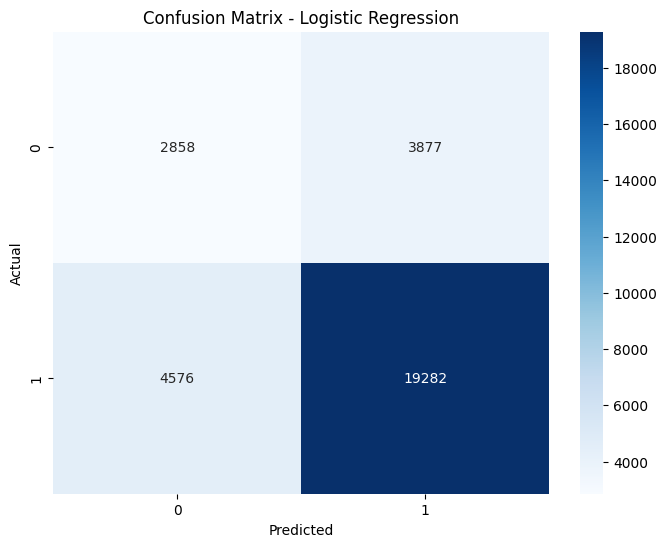

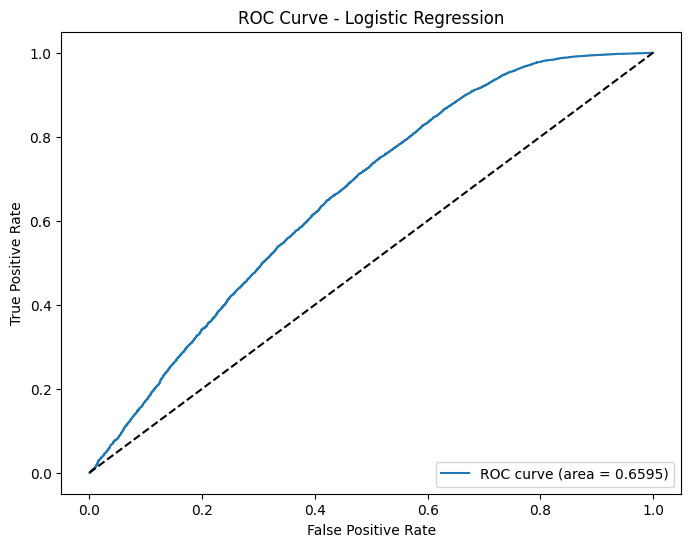


Training Random Forest model...
Training Random Forest...
Making predictions with Random Forest...

Random Forest Evaluation Metrics:
Accuracy: 0.8057
Weighted Precision: 0.7822
Weighted Recall: 0.8057
Weighted F1 Score: 0.7740
ROC AUC: 0.6997

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.27      0.38      6735
           1       0.82      0.96      0.88     23858

    accuracy                           0.81     30593
   macro avg       0.73      0.61      0.63     30593
weighted avg       0.78      0.81      0.77     30593



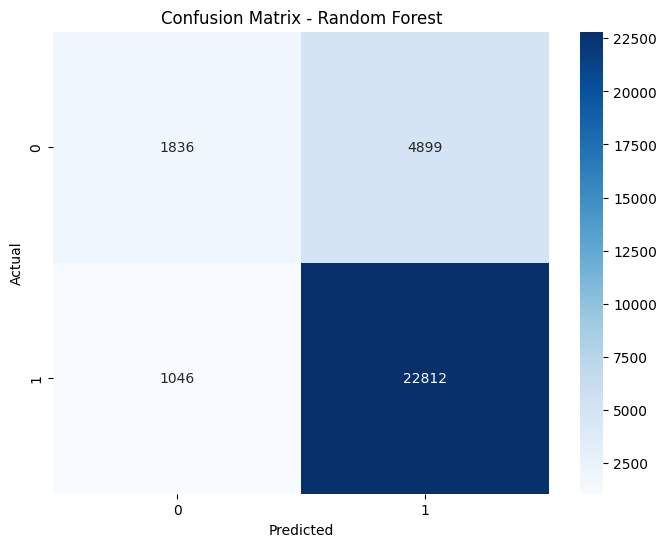

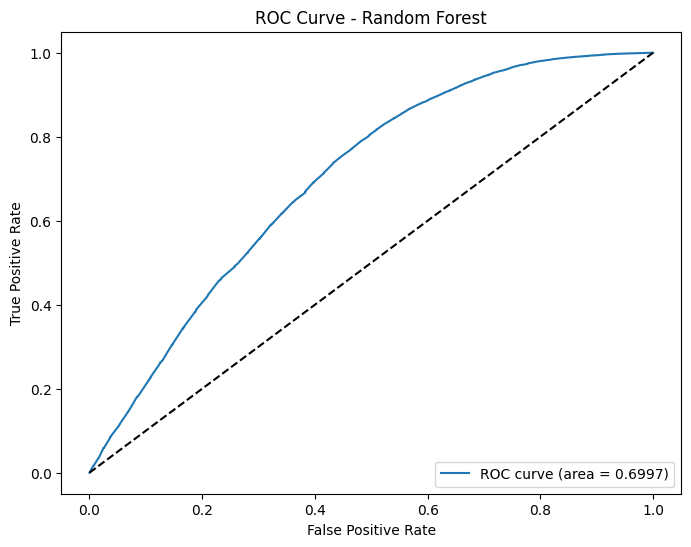


Training XGBoost model...
Training XGBoost...
Making predictions with XGBoost...

XGBoost Evaluation Metrics:
Accuracy: 0.7278
Weighted Precision: 0.7554
Weighted Recall: 0.7278
Weighted F1 Score: 0.7390
ROC AUC: 0.7019

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.52      0.46      6735
           1       0.85      0.79      0.82     23858

    accuracy                           0.73     30593
   macro avg       0.63      0.65      0.64     30593
weighted avg       0.76      0.73      0.74     30593



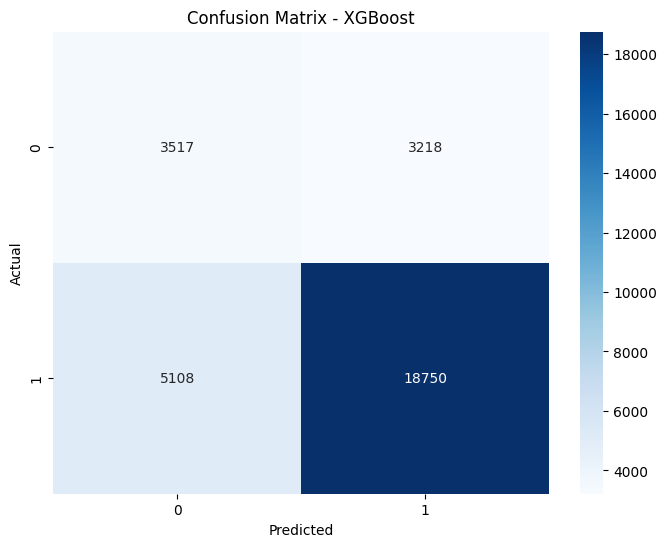

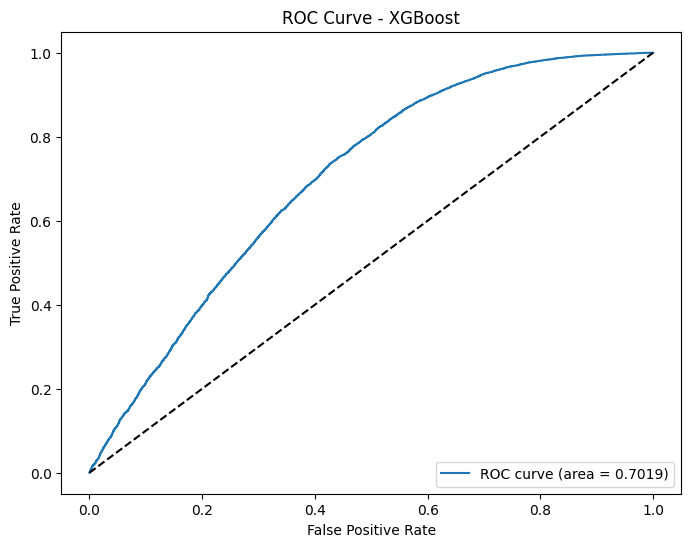


Training Deep Learning MLP model...
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

MLP Neural Network Evaluation Metrics:
Accuracy: 0.7310
Weighted Precision: 0.7513
Weighted Recall: 0.7310
Weighted F1 Score: 0.7397
ROC AUC: 0.6891

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      6735
           1       0.85      0.80      0.82     23858

    accuracy                           0.73     30593
   macro avg       0.63      0.65      0.63     30593
weighted avg       0.75      0.73      0.74     30593



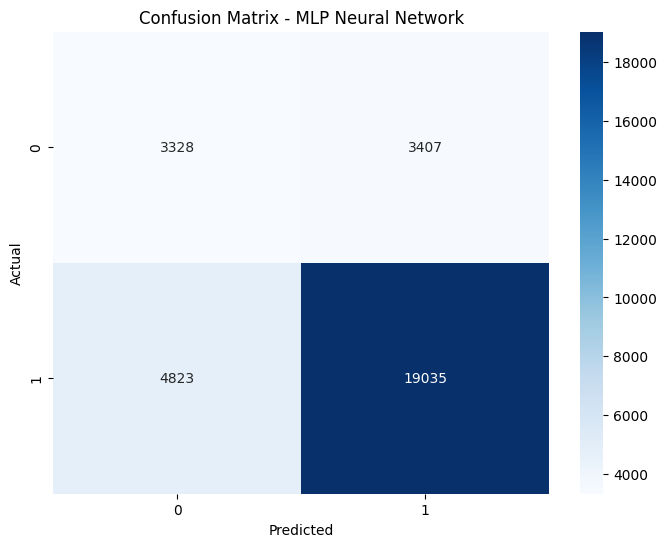

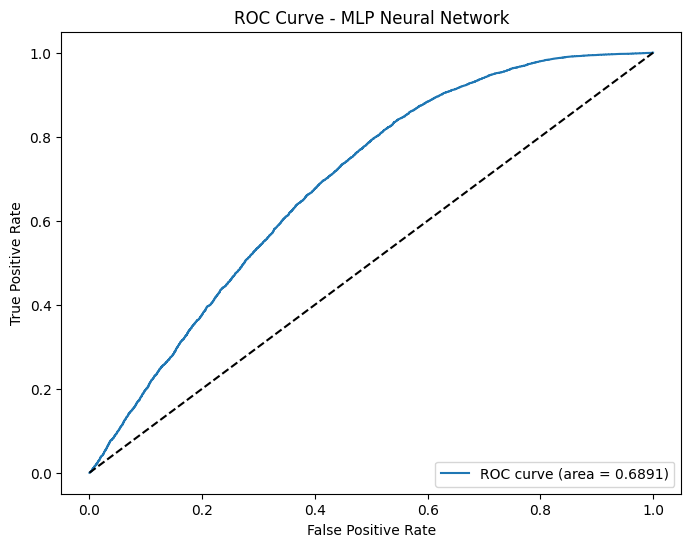


Model Comparison:
                 Model  Accuracy  Weighted Precision  Weighted Recall  \
0  Logistic Regression  0.723695            0.733934         0.723695   
1        Random Forest  0.805675            0.782230         0.805675   
2              XGBoost  0.727846            0.755384         0.727846   
3   MLP Neural Network  0.730984            0.751345         0.730984   

   Weighted F1 Score       AUC  
0           0.728457  0.659472  
1           0.774006  0.699684  
2           0.738978  0.701934  
3           0.739665  0.689139  

Best model based on Weighted F1 Score: Random Forest
--------------------------------------------------------------------------------


In [457]:
print("G. MODELING")

# Function to evaluate model with class weight handling for imbalanced data
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)

    # Make predictions
    print(f"Making predictions with {model_name}...")
    y_pred = model.predict(X_test)

    # For models that support predict_proba
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except:
        # If predict_proba is not available, use decision function or just predictions
        try:
            y_prob = model.decision_function(X_test)
        except:
            y_prob = y_pred  # Fallback

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # ROC AUC
    try:
        roc_auc = roc_auc_score(y_test, y_prob)
    except:
        roc_auc = 0.5  # Default to random classifier value

    # Print results
    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # Plot ROC curve if available
    try:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend(loc='lower right')
        plt.show()
    except:
        print(f"Warning: Could not plot ROC curve for {model_name}")

    return model, accuracy, precision, recall, f1, roc_auc

# Check class imbalance
class_counts = y_train.value_counts()
print("Class distribution in training set:")
print(class_counts)

# Calculate class weights
class_weight = {0: class_counts[1] / class_counts[0], 1: 1.0} if len(class_counts) > 1 else {0: 1.0, 1: 1.0}
print(f"Class weights: {class_weight}")

# 1. Logistic Regression with class weights
print("\nTraining Logistic Regression model...")
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight=class_weight)
log_reg_model, lr_acc, lr_prec, lr_rec, lr_f1, lr_auc = evaluate_model(
    log_reg, X_train, X_test, y_train, y_test, "Logistic Regression"
)

# 2. Random Forest with class weights
print("\nTraining Random Forest model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)
rf_model, rf_acc, rf_prec, rf_rec, rf_f1, rf_auc = evaluate_model(
    rf, X_train, X_test, y_train, y_test, "Random Forest"
)

# 3. XGBoost with scale_pos_weight for imbalance
print("\nTraining XGBoost model...")
# Calculate positive/negative ratio for scale_pos_weight
pos_neg_ratio = class_counts[0] / class_counts[1] if len(class_counts) > 1 and class_counts[1] > 0 else 1.0
try:
    xgb = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=pos_neg_ratio)
    xgb_model, xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_auc = evaluate_model(
        xgb, X_train, X_test, y_train, y_test, "XGBoost"
    )
    xgb_success = True
except Exception as e:
    print(f"Error training XGBoost: {e}")
    print("Skipping XGBoost model.")
    xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_auc = 0, 0, 0, 0, 0
    xgb_success = False

# 4. NEW: Deep Learning Model (MLP)
print("\nTraining Deep Learning MLP model...")
try:
    # Define the MLP model
    mlp_model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    mlp_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Add class weights to MLP
    mlp_class_weight = {0: class_weight[0], 1: class_weight[1]}

    # Train the model
    history = mlp_model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.2,
        class_weight=mlp_class_weight,
        verbose=0
    )

    # Evaluate the model
    y_pred_proba = mlp_model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    mlp_acc = accuracy_score(y_test, y_pred)
    mlp_prec = precision_score(y_test, y_pred, average='weighted')
    mlp_rec = recall_score(y_test, y_pred, average='weighted')
    mlp_f1 = f1_score(y_test, y_pred, average='weighted')
    mlp_auc = roc_auc_score(y_test, y_pred_proba)

    # Print results
    print("\nMLP Neural Network Evaluation Metrics:")
    print(f"Accuracy: {mlp_acc:.4f}")
    print(f"Weighted Precision: {mlp_prec:.4f}")
    print(f"Weighted Recall: {mlp_rec:.4f}")
    print(f"Weighted F1 Score: {mlp_f1:.4f}")
    print(f"ROC AUC: {mlp_auc:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - MLP Neural Network')
    plt.show()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {mlp_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - MLP Neural Network')
    plt.legend(loc='lower right')
    plt.show()

    mlp_success = True
except Exception as e:
    print(f"Error training MLP model: {e}")
    print("Skipping MLP model.")
    mlp_acc, mlp_prec, mlp_rec, mlp_f1, mlp_auc = 0, 0, 0, 0, 0
    mlp_success = False

# Compare models
models = ['Logistic Regression', 'Random Forest']
accuracy_scores = [lr_acc, rf_acc]
precision_scores = [lr_prec, rf_prec]
recall_scores = [lr_rec, rf_rec]
f1_scores = [lr_f1, rf_f1]
auc_scores = [lr_auc, rf_auc]

# Add XGBoost to comparison if it was successful
if xgb_success:
    models.append('XGBoost')
    accuracy_scores.append(xgb_acc)
    precision_scores.append(xgb_prec)
    recall_scores.append(xgb_rec)
    f1_scores.append(xgb_f1)
    auc_scores.append(xgb_auc)

# Add MLP to comparison if it was successful
if mlp_success:
    models.append('MLP Neural Network')
    accuracy_scores.append(mlp_acc)
    precision_scores.append(mlp_prec)
    recall_scores.append(mlp_rec)
    f1_scores.append(mlp_f1)
    auc_scores.append(mlp_auc)

# Create a comparison dataframe
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Weighted Precision': precision_scores,
    'Weighted Recall': recall_scores,
    'Weighted F1 Score': f1_scores,
    'AUC': auc_scores
})

print("\nModel Comparison:")
print(comparison_df)

# Find the best model based on F1 score
best_model_idx = comparison_df['Weighted F1 Score'].argmax()
best_model_name = comparison_df.iloc[best_model_idx]['Model']
print(f"\nBest model based on Weighted F1 Score: {best_model_name}")
print("-" * 80)

5 ROC AUC Curve Comparison for All Models
--------------------------------------------------------------------------------
957/957 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


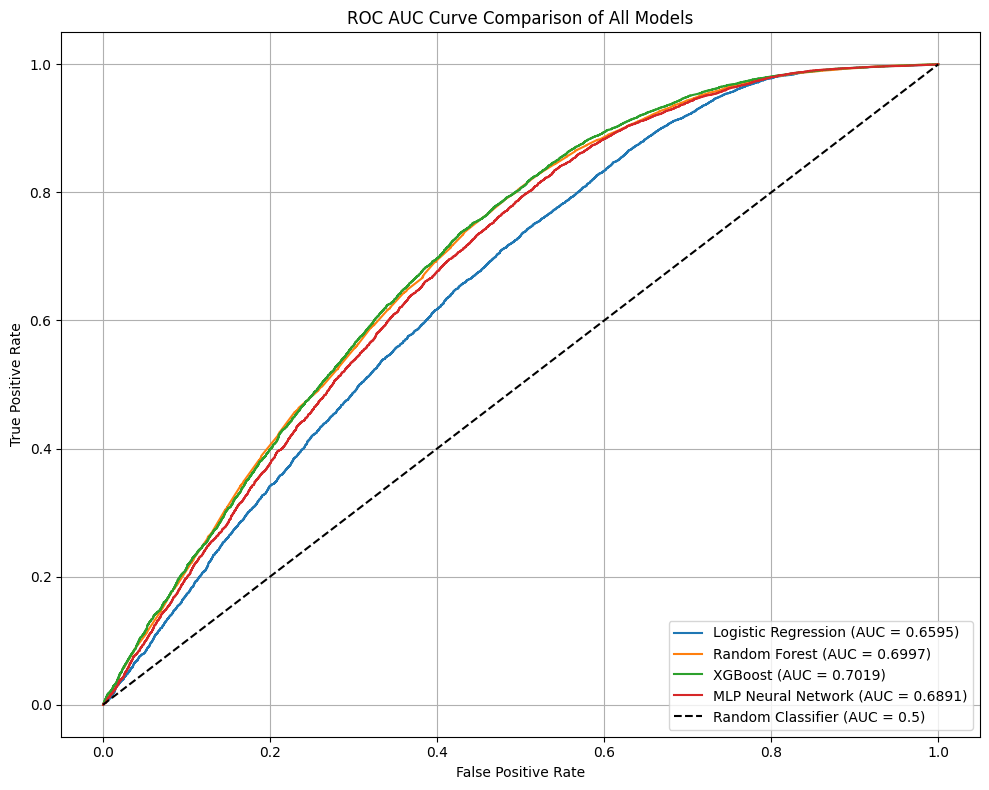

In [463]:
print("5 ROC AUC Curve Comparison for All Models")
print("-" * 80)

plt.figure(figsize=(10, 8))

# Plot for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.4f})')

# Plot for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.4f})')

# Plot for XGBoost (only if successful)
if xgb_success:
    fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
    plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {xgb_auc:.4f})')

# Plot for MLP Neural Network (only if successful)
if mlp_success:
    fpr_mlp, tpr_mlp, _ = roc_curve(y_test, mlp_model.predict(X_test).flatten())
    plt.plot(fpr_mlp, tpr_mlp, label=f'MLP Neural Network (AUC = {mlp_auc:.4f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve Comparison of All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

H. MODEL INTERPRETATION
Using a sample of 1000 test cases for analysis due to dataset size
Could not load cached importances, recomputing...


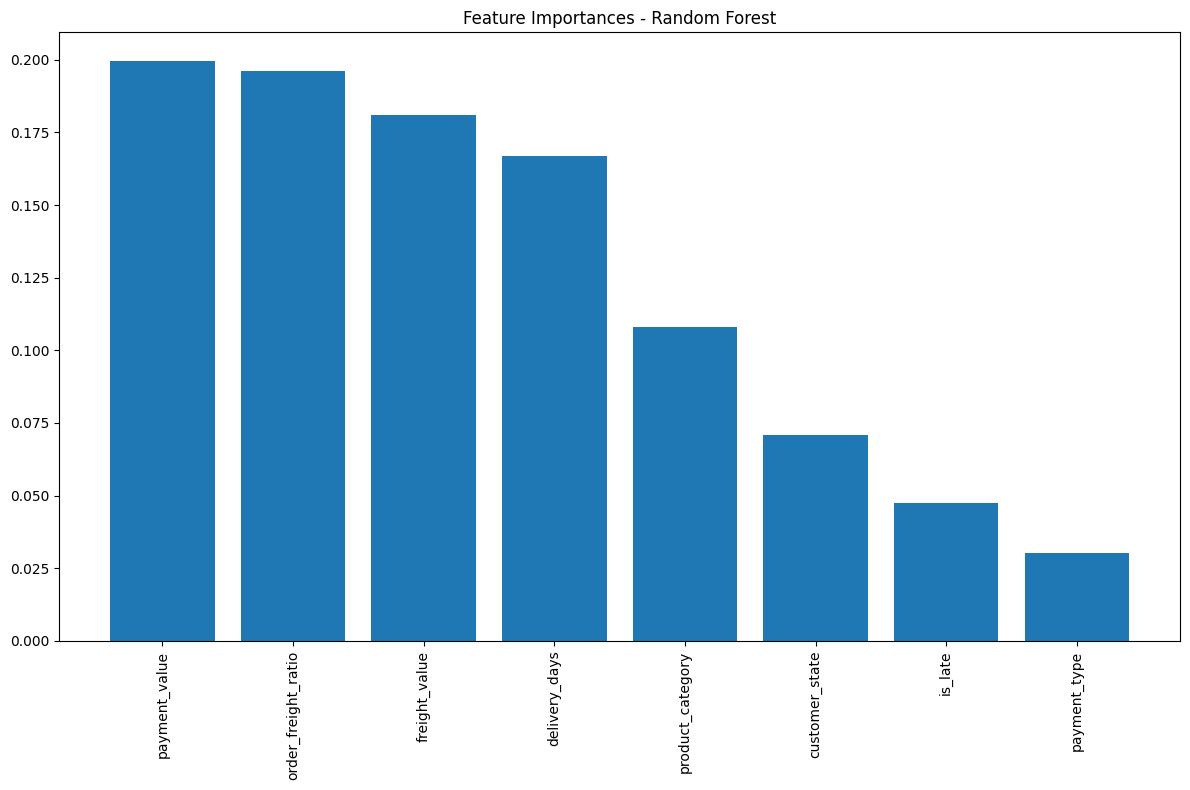

In [459]:
# H. MODEL INTERPRETATION
print("H. MODEL INTERPRETATION")

# Parameters to control execution
run_feature_importance = True
run_shap_analysis = True  # Set to False when you don't need SHAP plots
max_samples = 1000  # Maximum samples to use for analysis
perm_repeats = 3  # Number of repeats for permutation importance

# Function to safely extract feature importance
def get_feature_importance(model, model_name, X, y):
    try:
        if hasattr(model, "feature_importances_"):
            return model.feature_importances_
        elif hasattr(model, "coef_"):
            return np.abs(model.coef_[0])  # For linear models
        else:
            print(f"Model {model_name} doesn't have a standard feature importance attribute.")
            print("Using permutation importance instead.")
            # Use permutation importance with fewer repeats
            perm_importance = permutation_importance(model, X, y, n_repeats=perm_repeats, random_state=42)
            return perm_importance.importances_mean
    except Exception as e:
        print(f"Error extracting feature importance from {model_name}: {e}")
        print("Using permutation importance as fallback.")
        try:
            # Use permutation importance as fallback with fewer repeats
            perm_importance = permutation_importance(model, X, y, n_repeats=perm_repeats, random_state=42)
            return perm_importance.importances_mean
        except:
            return np.ones(X.shape[1]) / X.shape[1]  # Uniform importance

# Sample data for faster analysis
if X_test.shape[0] > max_samples:
    print(f"Using a sample of {max_samples} test cases for analysis due to dataset size")
    sample_indices = np.random.choice(X_test.shape[0], size=max_samples, replace=False)
    X_test_sample = X_test.iloc[sample_indices] if hasattr(X_test, 'iloc') else X_test[sample_indices]
    y_test_sample = y_test.iloc[sample_indices] if hasattr(y_test, 'iloc') else y_test[sample_indices]
else:
    X_test_sample = X_test
    y_test_sample = y_test

# Feature importance for the best model
best_model = None
if run_feature_importance:
    # Try to load cached importances if available
    import_cache_file = f'model_importances_{best_model_name}.pkl'
    importances = None

    try:
        if os.path.exists(import_cache_file):
            importances = joblib.load(import_cache_file)
            print(f"Loaded cached feature importances for {best_model_name}")
    except:
        print("Could not load cached importances, recomputing...")

    if importances is None:
        if best_model_name == 'Logistic Regression':
            best_model = log_reg_model
            importances = get_feature_importance(log_reg_model, "Logistic Regression", X_test_sample, y_test_sample)
        elif best_model_name == 'Random Forest':
            best_model = rf_model
            importances = get_feature_importance(rf_model, "Random Forest", X_test_sample, y_test_sample)
        elif best_model_name == 'XGBoost' and xgb_success:
            best_model = xgb_model
            importances = get_feature_importance(xgb_model, "XGBoost", X_test_sample, y_test_sample)
        elif best_model_name == 'MLP Neural Network' and mlp_success:
            print("Using permutation importance for MLP model...")

            # Create a wrapper class that meets scikit-learn estimator requirements
            class KerasWrapper:
                def __init__(self, model):
                    self.model = model

                def fit(self, X, y):
                    # Already fitted, just pass
                    return self

                def predict(self, X):
                    # Predict in batches for efficiency
                    batch_size = 128
                    return (self.model.predict(X, batch_size=batch_size, verbose=0) > 0.5).astype(int)

                def score(self, X, y):
                    return accuracy_score(y, self.predict(X))

            # Create wrapped model
            wrapped_model = KerasWrapper(mlp_model)

            # Now use permutation importance with the wrapper and fewer repeats
            perm_importance = permutation_importance(
                wrapped_model,
                X_test_sample, y_test_sample, n_repeats=perm_repeats, random_state=42
            )
            importances = perm_importance.importances_mean
        else:
            # Default to Random Forest if best model not available
            best_model = rf_model
            importances = get_feature_importance(rf_model, "Random Forest", X_test_sample, y_test_sample)
            print(f"Using Random Forest for feature importance as best model {best_model_name} is not available")

        # # Cache importances for future use
        # try:
        #     joblib.dump(importances, import_cache_file)
        #     print(f"Cached feature importances to {import_cache_file}")
        # except:
        #     print("Failed to cache importances, but continuing with analysis...")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    indices = np.argsort(importances)[::-1]
    plt.title(f'Feature Importances - {best_model_name}')
    plt.bar(range(X_test_sample.shape[1]), importances[indices], align='center')
    plt.xticks(range(X_test_sample.shape[1]), [selected_features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig(f'feature_importance_{best_model_name}.png')
    plt.show()

In [462]:
# Conclusion and business recommendations
print("CONCLUSION")
print("Based on our analysis, the following factors have the most significant impact on customer satisfaction:")

# Extract top features and their importance
top_features = [(selected_features[i], importances[i]) for i in indices[:min(5, len(indices))]]
for feature, importance in top_features:
    print(f"- {feature}: {importance:.4f}")

CONCLUSION
Based on our analysis, the following factors have the most significant impact on customer satisfaction:
- payment_value: 0.1995
- order_freight_ratio: 0.1960
- freight_value: 0.1809
- delivery_days: 0.1670
- product_category: 0.1080
